In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Dropout

In [2]:
# Step 1: Load and prepare embeddings
def load_kmer_embeddings(path):
    """Load pre-trained k-mer embeddings from file"""
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = ["Kmer"] + [f"Dim_{i}" for i in range(128)]
    return {row["Kmer"]: row[1:].values for _, row in df.iterrows()}

kmer_to_embedding = load_kmer_embeddings("kmers_embedding_human_dengue.txt")

In [3]:
# Step 2: Feature extraction functions
def process_sequence(sequence, k=4, max_len=100):
    """Extract and embed top k-mers from a protein sequence"""
    if not isinstance(sequence, str) or len(sequence) < k:
        return np.zeros((max_len, 128), dtype=np.float32)
    
    # Extract top k-mers by frequency
    kmers = [sequence[i:i+k] for i in range(len(sequence)-k+1)]
    top_kmers = pd.Series(kmers).value_counts().nlargest(100).index.tolist()
    
    # Create embedding matrix with padding/truncation
    embeddings = np.array([kmer_to_embedding.get(k, np.zeros(128)) for k in top_kmers], dtype=np.float32)
    if len(embeddings) < max_len:
        padding = np.zeros((max_len - len(embeddings), 128), dtype=np.float32)
        return np.vstack([embeddings, padding])
    return embeddings[:max_len]

In [4]:
# Step 3: Data preparation
protein_data = pd.read_csv("Human.csv")
sequences = [process_sequence(s) for s in protein_data["Human Sequence"]]
X = np.array(sequences, dtype=np.float32)

In [5]:
# Step 4: Enhanced BiLSTM Autoencoder with Optimal Dropout
def build_bilstm_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder with optimized dropout
    x = Bidirectional(LSTM(64, return_sequences=True,
                         dropout=0.4,  # Increased input dropout
                         recurrent_dropout=0.3))(inputs)  # Increased recurrent dropout
    
    x = Bidirectional(LSTM(32, return_sequences=True,
                         dropout=0.4,
                         recurrent_dropout=0.3))(x)
    
    # Decoder with dropout
    x = Bidirectional(LSTM(64, return_sequences=True,
                         dropout=0.4,
                         recurrent_dropout=0.3))(x)
    
    outputs = TimeDistributed(Dense(128, activation='relu'))(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Early stopping configuration
early_stop = EarlyStopping(
    monitor='loss',
    patience=8,  # Reduced patience for faster convergence
    restore_best_weights=True,
    verbose=1
)

# Build model
model = build_bilstm_autoencoder(X.shape[1:])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 64)             │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 128)            │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,592 (869.50 KB)

 Trainable params: 222,592 (869.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Step 5: Train with optimized parameters
history = model.fit(
    X, X,
    epochs=180,  
    batch_size=64,  # Increased batch size
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 492ms/step - loss: 0.9349
Epoch 2/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - loss: 0.9276
Epoch 3/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - loss: 0.9356
Epoch 4/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 470ms/step - loss: 0.9323
Epoch 5/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - loss: 0.9273
Epoch 6/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - loss: 0.9282
Epoch 7/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 752ms/step - loss: 0.9349
Epoch 8/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 610ms/step - loss: 0.9275
Epoch 9/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 560ms/step - loss: 0.9267
Epoch 10/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 557ms/step - loss: 0.9228
Epoch 11/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 619ms/step - loss: 0.9226
Epoch 12/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 602ms/step - loss: 0.9251
Epoch 13/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 695ms/step - loss: 0.9247
Epoch 14/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 724ms/step - loss: 0.9163
Epoch 15/180
15/15 ━━━━━━━━━━━━━━━━━━━━

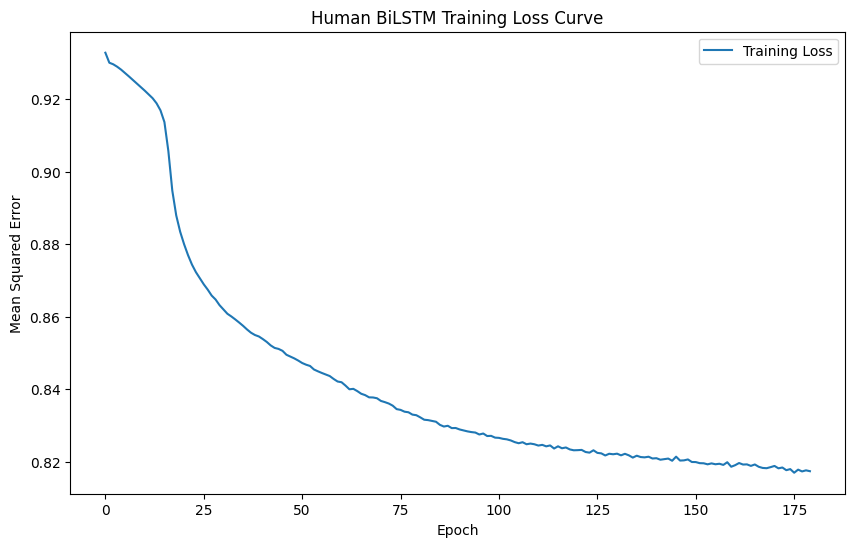

In [7]:
# Step 6: Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Human BiLSTM Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(False)
plt.show()

In [8]:
# Step 7: Generate and save final embeddings

# 1. Get embeddings from model
embeddings = model.predict(X)  # Shape: (1303, 100, 128)

# 2. Convert 3D embeddings to 2D by averaging across sequence length
embeddings_2d = np.mean(embeddings, axis=1)  # Shape: (1303, 128)

# 3. Create DataFrame with 2D embeddings
result_df = pd.DataFrame(embeddings_2d, columns=[f"Dim_{i}" for i in range(128)])

# 4. Add original sequences
result_df['Protein_Sequence'] = protein_data["Human Sequence"]

# 5. Save to CSV
result_df.to_csv("drop_Human_BiLSTM_Final_Embeddings.csv", index=False)


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step


In [9]:
# Save the entire model (architecture + weights + optimizer state)
model.save("drop_Human_bilstm_autoencoder_model.keras")  # Recommended format (.keras)

# Optional: Save just the weights
model.save_weights("drop_Human_bilstm_autoencoder_weights.weights.h5")

# Optional: Save token-to-embedding dictionary for future preprocessing
import pickle
with open("kmer_embeddings.pkl", "wb") as f:
    pickle.dump(kmer_to_embedding, f)


#### Dengue

In [10]:
# Step 3: Data preparation
protein_data = pd.read_csv("Dengue.csv")
sequences = [process_sequence(s) for s in protein_data["Dengue Sequence"]]
X = np.array(sequences, dtype=np.float32)

In [11]:
# Step 4: Define BiLSTM model with training capability
def build_bilstm_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder with dropout
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Dropout(0.3)(x)  # Additional dropout between LSTM layers
    x = Bidirectional(LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
    
    # Decoder with dropout
    x = Dropout(0.3)(x)  # Dropout before decoder
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)
    outputs = TimeDistributed(Dense(128, activation='relu'))(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_bilstm_autoencoder(X.shape[1:])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100, 64)             │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 100, 128)            │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,592 (869.50 KB)

 Trainable params: 222,592 (869.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Step 5: Train model with early stopping
history = model.fit(
    X, X,  # Auto-encoder training with matching 3D shapes
    epochs=300,  # Increased max epochs since we have early stopping
    batch_size=22,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - loss: 0.9515
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.9507
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.9498
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.9499
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.9492
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.9488
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.9478
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.9477
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.9475
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.9470
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.9466
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.9465
Epoch 13/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.9459
Epoch 14/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.9459
Epoch 15/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.9457
Epoch

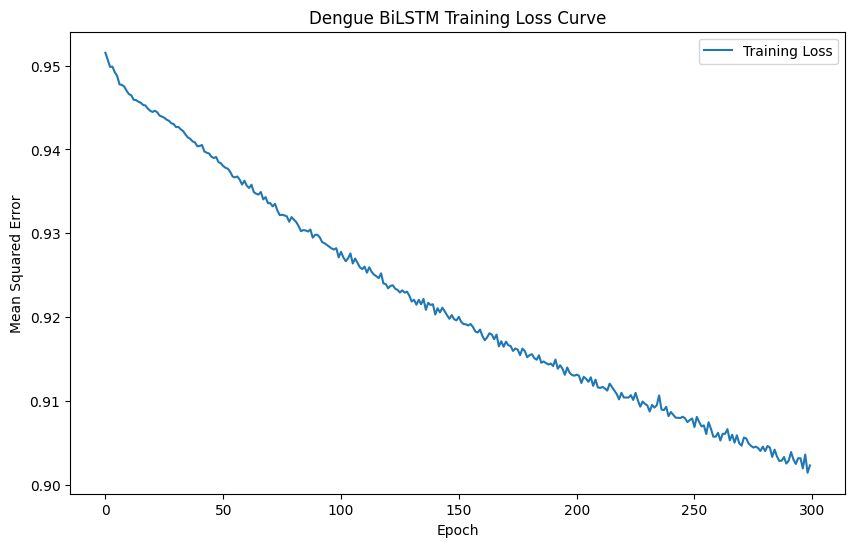

In [16]:
# Step 6: Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Dengue BiLSTM Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(False)
plt.show()

In [14]:
# Step 7: Generate and save final embeddings

# 1. Get embeddings from model
embeddings = model.predict(X)  # Shape: (1303, 100, 128)

# 2. Convert 3D embeddings to 2D by averaging across sequence length
embeddings_2d = np.mean(embeddings, axis=1)  # Shape: (1303, 128)

# 3. Create DataFrame with 2D embeddings
result_df = pd.DataFrame(embeddings_2d, columns=[f"Dim_{i}" for i in range(128)])

# 4. Add original sequences
result_df['Dengue_Sequence'] = protein_data["Dengue Sequence"]

# 5. Save to CSV
result_df.to_csv("drop_Dengue_BiLSTM_Final_Embeddings.csv", index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [15]:
# Save the entire model (architecture + weights + optimizer state)
model.save("drop_Dengue_bilstm_autoencoder_model.keras")  # Recommended format (.keras)

# Optional: Save just the weights
model.save_weights("drop_Dengue_bilstm_autoencoder_weights.weights.h5")

# Optional: Save token-to-embedding dictionary for future preprocessing
import pickle
with open("kmer_embeddings.pkl", "wb") as f:
    pickle.dump(kmer_to_embedding, f)
